In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Multimodal_machine_learning/Speaker_identification/speaker-similarity
!pwd

/content/drive/MyDrive/Multimodal_machine_learning/Speaker_identification/speaker-similarity
/content/drive/MyDrive/Multimodal_machine_learning/Speaker_identification/speaker-similarity


In [3]:
!pip3 install librosa

In [4]:
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

2.5.0


## Dataset

We check given directory to find all available *.wav* files.

In [5]:
# helper
def contains_number(s):
    return any(i.isdigit() for i in s)

In [6]:
#check source directory and find classes
source_dir = '/content/drive/MyDrive/Multimodal_machine_learning/Speaker_identification/VoxCeleb1_dataset/Audio_files/vox1_dev_wav_subsampling/wav'
# source_dir = './audio/'
speakers = [name for name in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, name))]
print(speakers)
raw = []
for speaker in speakers:
    path = os.path.join(source_dir, speaker) + '/'
    print('checking dir:', path)
    folders = [f for f in os.listdir(path) if not f.startswith('.') ]
    for folder in folders:
        clip_path = os.path.join(path, folder) + '/'
        print(clip_path)
        clips = [f for f in os.listdir(clip_path) if f.endswith('.wav')]
        for clip in clips:
            raw.append({'speaker': speaker, 'path':clip_path+clip})

['id10001', 'id10002', 'id10003', 'id10004', 'id10005', 'id10006', 'id10007', 'id10008', 'id10010', 'id10009', 'id10011', 'id10012', 'id10013', 'id10014', 'id10015', 'id10016', 'id10017', 'id10018', 'id10019', 'id10020']
checking dir: /content/drive/MyDrive/Multimodal_machine_learning/Speaker_identification/VoxCeleb1_dataset/Audio_files/vox1_dev_wav_subsampling/wav/id10001/
/content/drive/MyDrive/Multimodal_machine_learning/Speaker_identification/VoxCeleb1_dataset/Audio_files/vox1_dev_wav_subsampling/wav/id10001/Y8hIVOBuels/
/content/drive/MyDrive/Multimodal_machine_learning/Speaker_identification/VoxCeleb1_dataset/Audio_files/vox1_dev_wav_subsampling/wav/id10001/7gWzIy6yIIk/
/content/drive/MyDrive/Multimodal_machine_learning/Speaker_identification/VoxCeleb1_dataset/Audio_files/vox1_dev_wav_subsampling/wav/id10001/7w0IBEWc9Qw/
/content/drive/MyDrive/Multimodal_machine_learning/Speaker_identification/VoxCeleb1_dataset/Audio_files/vox1_dev_wav_subsampling/wav/id10001/1zcIwhmdeo4/
/conten

In [7]:
df = pd.DataFrame(raw)
df = df[:600]
print(df.shape)
df.head()

(600, 2)


,speaker,path
0,id10001,/content/drive/MyDrive/Multimodal_machine_lear...
1,id10001,/content/drive/MyDrive/Multimodal_machine_lear...
2,id10001,/content/drive/MyDrive/Multimodal_machine_lear...
3,id10001,/content/drive/MyDrive/Multimodal_machine_lear...
4,id10001,/content/drive/MyDrive/Multimodal_machine_lear...


## Preprocessing and Feuture Extraction

* We split the dataset as 80% train and 20% test. The split is performed per speaker and not the entire dataset
* Then, we extract MFCC and Delta features

In [8]:
# create test dataframe, keep 0.7 of each speaker as train and 0.3 as test
train_split = 0.7
df_train_list = []
df_test_list = []
for id in df['speaker'].unique():
    speaker = df.loc[df['speaker'] == id]
    #suffle and split dataset
    speaker = speaker.sample(frac=1, replace=False, random_state=42)
    train_indices = int(round(train_split*len(speaker)))
    train = speaker[:train_indices]
    test = speaker[:len(speaker) - train_indices]
    df_train_list.append(train)
    df_test_list.append(test)

df_train = pd.concat(df_train_list)
df_test = pd.concat(df_test_list)
print(f'Train set size: {df_train.shape}, Test set size {df_test.shape}')

# sanity check, check if both train and test sets have same speakers
b = set(df_train['speaker'].unique()) == set(df_test['speaker'].unique())
b

Train set size: (421, 2), Test set size (179, 2)


True

In [9]:
n_mfcc = 20
def extract_mfcc(clip, nr_mfcc):
    signal ,sr = librosa.load(clip)
    mfcc_feature = librosa.feature.mfcc(signal, n_mfcc=nr_mfcc, sr=sr, hop_length=256)
    delta_feature = librosa.feature.delta(mfcc_feature)
    # lpc_feature = librosa.lpc(signal, 16)
    
    mfcc_feature = np.mean(mfcc_feature.T,axis=0)
    delta_feature = np.mean(delta_feature.T, axis=0)
    # lpc_feature = np.mean(lpc_feature.T, axis=0)
    # lpc_feature = round(lpc_feature, 5)

    # return pd.Series([mfcc_feature, delta_feature, lpc_feature])
    return pd.Series([mfcc_feature, delta_feature])

In [10]:
df_train[['mfcc','delta']] = df_train['path'].apply(lambda p: extract_mfcc(p, n_mfcc))
df_test[['mfcc','delta']] = df_test['path'].apply(lambda p: extract_mfcc(p, n_mfcc))
# df_train[['mfcc','delta','lpc']] = df_train['path'].apply(lambda p: extract_mfcc(p, n_mfcc))
# df_test[['mfcc','delta','lpc']] = df_test['path'].apply(lambda p: extract_mfcc(p, n_mfcc))

In [11]:
df_train.head()

,speaker,path,mfcc,delta
4,id10001,/content/drive/MyDrive/Multimodal_machine_lear...,"[-303.3497, 137.01996, -37.719727, 36.205246, ...","[-0.31446058, 0.09602206, 0.090558305, 0.06451..."
35,id10001,/content/drive/MyDrive/Multimodal_machine_lear...,"[-398.10855, 162.33047, -33.30646, 27.986618, ...","[0.11844375, -0.046207756, 0.027276471, -0.050..."
10,id10001,/content/drive/MyDrive/Multimodal_machine_lear...,"[-278.13583, 119.55525, -38.819412, 53.126904,...","[0.17802209, -0.04433923, -0.10072344, 0.03413..."
0,id10001,/content/drive/MyDrive/Multimodal_machine_lear...,"[-395.30148, 152.98679, -22.925863, 58.379425,...","[-0.47506902, 0.23962286, 0.14173834, -0.13870..."
45,id10001,/content/drive/MyDrive/Multimodal_machine_lear...,"[-411.9823, 163.73741, -34.576183, 21.184721, ...","[-0.14435834, 0.1329984, 0.12089822, 0.0214034..."


In [12]:
df_test.head()

,speaker,path,mfcc,delta
4,id10001,/content/drive/MyDrive/Multimodal_machine_lear...,"[-303.3497, 137.01996, -37.719727, 36.205246, ...","[-0.31446058, 0.09602206, 0.090558305, 0.06451..."
35,id10001,/content/drive/MyDrive/Multimodal_machine_lear...,"[-398.10855, 162.33047, -33.30646, 27.986618, ...","[0.11844375, -0.046207756, 0.027276471, -0.050..."
10,id10001,/content/drive/MyDrive/Multimodal_machine_lear...,"[-278.13583, 119.55525, -38.819412, 53.126904,...","[0.17802209, -0.04433923, -0.10072344, 0.03413..."
0,id10001,/content/drive/MyDrive/Multimodal_machine_lear...,"[-395.30148, 152.98679, -22.925863, 58.379425,...","[-0.47506902, 0.23962286, 0.14173834, -0.13870..."
45,id10001,/content/drive/MyDrive/Multimodal_machine_lear...,"[-411.9823, 163.73741, -34.576183, 21.184721, ...","[-0.14435834, 0.1329984, 0.12089822, 0.0214034..."


In [13]:
#split dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# keep mfcc and delta columns
X = df_train.iloc[:,2:4]
# X = df_train.iloc[:,2:5]

# keep speaker colum
y = df_train.iloc[:,0]

le = LabelEncoder()
le.fit(list(y))
num_labels=len(list(le.classes_))

y = le.fit_transform(y)
print(f'Number of speakers is {num_labels}')

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=21)

X_train = np.hstack((X_train['mfcc'].to_list(),X_train['delta'].to_list()))
X_val = np.hstack((X_val['mfcc'].to_list(),X_val['delta'].to_list()))
# X_train = np.hstack((X_train['mfcc'].to_list(),X_train['delta'].to_list(),X_train['lpc'].to_list()))
# X_val = np.hstack((X_val['mfcc'].to_list(),X_val['delta'].to_list(),X_val['lpc'].to_list()))
print(f'Train set size: {X_train.shape}, Validation set size {X_val.shape}')


Number of speakers is 6
Train set size: (294, 40), Validation set size (127, 40)


## Deep Learning Model

In [14]:
model=Sequential()
###first layer
model.add(Dense(100,input_shape=(X_train.shape[1],)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###second layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###third layer
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))

###final layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))
model.compile(loss='sparse_categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               4100      
_________________________________________________________________
activation (Activation)      (None, 100)               0         
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               20200     
_________________________________________________________________
activation_1 (Activation)    (None, 200)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               2

In [15]:
## Train model
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 

num_epochs = 50
num_batch_size = 8


earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
checkpointer = ModelCheckpoint(filepath='saved_models/speakers_classification.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

model_h = model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, 
          validation_data=(X_val, y_val), callbacks=[checkpointer, earlystopping], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/50
37/37 [==============================] - 1s 7ms/step - loss: 53.4805 - accuracy: 0.1769 - val_loss: 11.9909 - val_accuracy: 0.2362

Epoch 00001: val_loss improved from inf to 11.99087, saving model to saved_models/speakers_classification.hdf5
Epoch 2/50
37/37 [==============================] - 0s 3ms/step - loss: 26.7240 - accuracy: 0.2245 - val_loss: 2.9303 - val_accuracy: 0.2992

Epoch 00002: val_loss improved from 11.99087 to 2.93026, saving model to saved_models/speakers_classification.hdf5
Epoch 3/50
37/37 [==============================] - 0s 3ms/step - loss: 18.5935 - accuracy: 0.1939 - val_loss: 2.4543 - val_accuracy: 0.1811

Epoch 00003: val_loss improved from 2.93026 to 2.45430, saving model to saved_models/speakers_classification.hdf5
Epoch 4/50
37/37 [==============================] - 0s 3ms/step - loss: 13.6974 - accuracy: 0.2109 - val_loss: 2.0518 - val_accuracy: 0.1339

Epoch 00004: val_loss improved from 2.45430 to 2.05179, saving model to saved_models/speake

### Check training history

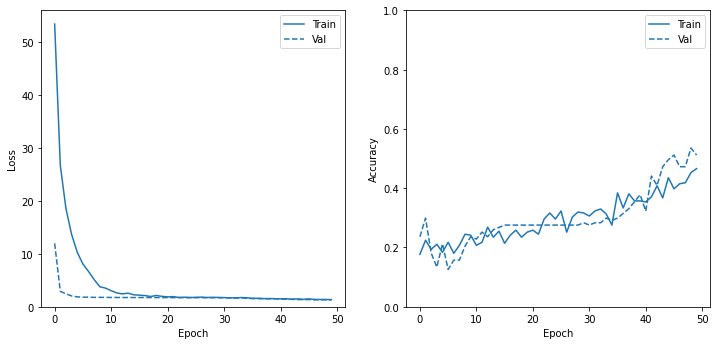

In [16]:
# import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,12)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
def plot_metrics(history):
  metrics = ['loss', 'accuracy']#, 'f1_m', 'recall_m']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

plot_metrics(model_h)

### Predict and Classification Report

In [27]:
from sklearn.metrics import classification_report

X_test = np.hstack((df_test['mfcc'].to_list(),df_test['delta'].to_list()))
# X_test = np.hstack((df_test['mfcc'].to_list(),df_test['delta'].to_list(),df_test['lpc'].to_list()))
print(X_test.shape)
y_true = df_test['speaker']

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_pred = le.classes_[y_pred]
print(y_pred)

print(classification_report(y_true, y_pred, target_names=le.classes_))

# confusion matrix
confusion = metrics.confusion_matrix(y_true, y_pred)
print('Confusion Matrix\n')
print(confusion)

(179, 40)
['id10004' 'id10004' 'id10004' 'id10004' 'id10004' 'id10003' 'id10004'
 'id10006' 'id10004' 'id10004' 'id10004' 'id10004' 'id10003' 'id10004'
 'id10004' 'id10004' 'id10003' 'id10004' 'id10004' 'id10004' 'id10004'
 'id10004' 'id10004' 'id10002' 'id10002' 'id10002' 'id10002' 'id10002'
 'id10002' 'id10002' 'id10002' 'id10002' 'id10002' 'id10003' 'id10002'
 'id10002' 'id10002' 'id10003' 'id10003' 'id10002' 'id10002' 'id10003'
 'id10002' 'id10002' 'id10002' 'id10002' 'id10002' 'id10004' 'id10002'
 'id10002' 'id10002' 'id10002' 'id10003' 'id10002' 'id10002' 'id10002'
 'id10002' 'id10002' 'id10002' 'id10002' 'id10003' 'id10002' 'id10003'
 'id10003' 'id10003' 'id10003' 'id10003' 'id10003' 'id10003' 'id10002'
 'id10002' 'id10002' 'id10003' 'id10003' 'id10003' 'id10004' 'id10003'
 'id10002' 'id10002' 'id10003' 'id10003' 'id10003' 'id10003' 'id10003'
 'id10004' 'id10004' 'id10003' 'id10003' 'id10004' 'id10002' 'id10003'
 'id10003' 'id10003' 'id10003' 'id10003' 'id10002' 'id10003' 'id100

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# clip = '/Users/vpapadop/Documents/GitHub/speaker-similarity/vox_dev_wav/wav/id10001/1zcIwhmdeo4/00001.wav'
# tmp = pd.DataFrame()
# tmp[['mfcc', 'delta']] = extract_mfcc(clip,20)
# X_tmp = np.hstack((tmp['mfcc'].to_list(),tmp['delta'].to_list()))
# X_tmp = np.expand_dims(X_tmp, axis=0)
# print(X_tmp.shape)

# y_pred = model.predict(X_tmp)
# print(y_pred)

## Gausian Mixture Model